In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Callable

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

device = torch.device('cuda:1' if torch.has_cudnn else 'cpu')
%matplotlib inline

In [8]:
# f(x, y) = r
class Representer(nn.Module):
    def __init__(self, x_y_dim, hidden_dim, r_dim):
        super().__init__()

        self.fc1 = nn.Linear(x_y_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, r_dim)
        self.activation = nn.Softplus()

    def forward(self, x_y):
        hidden = self.activation(self.fc1(x_y))
        hidden = self.activation(self.fc2(hidden))
        hidden = self.activation(self.fc3(hidden))
        r_i = self.fc4(hidden)
        return r_i.mean(dim=0)

In [9]:
# q(z|r) = q(z|x, y)
class ZDistribution(nn.Module):
    def __init__(self, r_dim, hidden_dim, z_dim):
        super().__init__()

#         self.fc1 = nn.Linear(r_dim, hidden_dim)
#         self.fc2a = nn.Linear(hidden_dim, z_dim)
#         self.fc2b = nn.Linear(hidden_dim, z_dim)

#         self.activation = nn.Softplus()
        self.softplus = nn.Softplus()
#         self.sigmoid = nn.Sigmoid()

    def forward(self, r):
#         hidden = self.activation(self.fc1(r))
#         z_loc = self.fc2a(hidden)
#         z_scale = self.softplus(self.fc2b(hidden))
        n_features = len(r)
        z_loc = r[:n_features // 2]
        z_scale = self.softplus(r[n_features // 2:])

        return z_loc, z_scale

In [10]:
# y_mean = f(z, x)
class Predictor(nn.Module):
    def __init__(self, z_x_dim, hidden_dim, output_dim):
        super().__init__()

        self.fc1 = nn.Linear(z_x_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Softplus()

    def forward(self, z_x):
        hidden = self.activation(self.fc1(z_x))
        hidden = self.activation(self.fc2(hidden))
        hidden = self.activation(self.fc3(hidden))
        hidden = self.activation(self.fc4(hidden))
        y_mean = self.fc5(hidden)
        return y_mean

In [59]:
class NP(nn.Module):
    def __init__(self, x_dim: int, y_dim: int, hidden_dim: int=8, r_dim: int=2, z_dim: int=2):
        super().__init__()

        self.representer = Representer(x_dim + y_dim, hidden_dim, r_dim)
        self.z_distribution = ZDistribution(r_dim, hidden_dim, z_dim)
        self.predictor = Predictor(z_dim + x_dim, hidden_dim, y_dim)
        self.n_samples = 30
        self.cnp_mode = False

    def forward(self, n_context, x_all, y_all, train: bool=True, return_z=False):
        y_scale = 0.05

        x_context = x_all[:n_context]
        y_context = y_all[:n_context]
        x_target = x_all[n_context:]
        y_target = y_all[n_context:]

        # the prior is q(z|x_C, y_C)
        r_context = self.representer(torch.cat((x_context, y_context), dim=1))
        r_all = self.representer(torch.cat((x_all, y_all), dim=1))

        z_loc_context, z_scale_context = self.z_distribution(r_context)
        z_loc_all, z_scale_all = self.z_distribution(r_all)

        z_normal_all = torch.distributions.Normal(z_loc_all, z_scale_all)
        z_normal_context = torch.distributions.Normal(z_loc_context, z_scale_context)

#         fixed_sigma = torch.tensor(1.).to(device)
#         z_normal_all = torch.distributions.Normal(z_loc_all, fixed_sigma)
#         z_normal_context = torch.distributions.Normal(z_loc_context, fixed_sigma)
                
        if self.cnp_mode:
            z = z_loc_all.view(-1, 1).expand(self.n_samples, -1)
        else:
            z = z_normal_all.sample((self.n_samples,))
    
        if return_z:
            return z_loc_all, z_scale_all, z_loc_context, z_scale_context
        
        x = x_target if train else x_all
        
        # broadcast z and x to the same shape[:-1] : (n_samples, batch_size, n_features)
        batch_size = len(x)
        z = z.view(self.n_samples, 1, -1).expand(-1, batch_size, -1)
        x = x.view(1, batch_size, -1).expand(self.n_samples, -1, -1)

        z_x = torch.cat((z, x), dim=-1)
        y_mean = self.predictor(z_x)

        kl = torch.distributions.kl_divergence(z_normal_all, z_normal_context).sum()
        
        return y_mean, y_scale, kl

In [17]:
def compute_log_likelihood(y_loc, y_scale, y_target):
    normal = torch.distributions.Normal(y_loc, y_scale)
    # sum over points, average over samples from z
    return normal.log_prob(y_target).sum(dim=-1).mean()

# Kaspar's 1st Experiment
* Note that the exact architecture of the modules above may be different if they've been changed for experimenting with other tasks

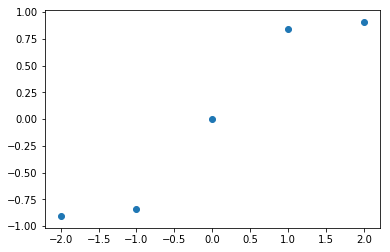

In [18]:
x_min = -2
x_max = 2
x = np.array([[-2, -1, 0, 1, 2]]).T
y = np.sin(x)
plt.scatter(x, y)

x = torch.tensor(x).float().to(device)
y = torch.tensor(y).float().to(device)

In [23]:
x_dim = 1
y_dim = 1
learning_rate = 1e-3
hidden_dim = 8
r_dim = 4
z_dim = r_dim // 2

nprocess = NP(x_dim, y_dim, hidden_dim, r_dim, z_dim).to(device)
optimizer = torch.optim.Adam(nprocess.parameters(), learning_rate)

In [24]:
n_steps = 5_000

shuffle_idx = list(range(len(x)))

losses = []
kls = []
log_likelihoods = []
for step in range(n_steps):
    optimizer.zero_grad()

    np.random.shuffle(shuffle_idx)
    n_context = np.random.randint(1, len(x))    

    y_loc, y_scale, kl = nprocess(n_context, x[shuffle_idx], y[shuffle_idx])

    y_target = y[shuffle_idx][n_context:]
    log_likelihood = compute_log_likelihood(y_loc, y_scale, y_target)
    loss = -log_likelihood + kl
    
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    kls.append(kl.item())
    log_likelihoods.append(log_likelihood.item())
    if step % 500 == 0:
        print(f"{step}: {np.mean(losses[-500:]):,.3f}")

0: 184.095
500: 77.108
1000: 4.297
1500: 1.880
2000: 0.023
2500: -1.064
3000: -1.583
3500: -1.858
4000: -2.018
4500: -2.063


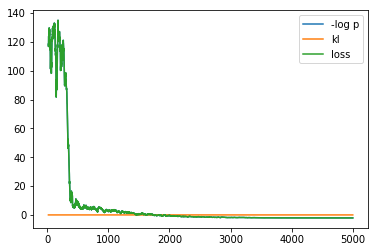

In [25]:
(pd.DataFrame({'loss': losses, 'kl': kls, '-log p': -np.array(log_likelihoods)})
   .rolling(window=20).mean().plot()
)
plt.legend()

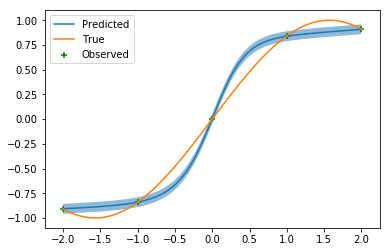

In [26]:
x_plot = torch.cat((x, torch.linspace(-2, 2, 100).to(device).view(-1, 1)), dim=0)
y_plot = torch.sin(x_plot)

y_loc, y_scale, _ = nprocess(5, x_plot, y_plot)
x_plot = x_plot[5:].cpu().numpy().ravel()
y_plot = y_plot[5:].cpu().numpy().ravel()
y_loc = y_loc[0].detach().cpu().numpy().ravel()

plt.plot(x_plot, y_loc, label='Predicted')
plt.fill_between(x_plot, y_loc - y_scale, y_loc + y_scale, alpha=0.5)
plt.plot(x_plot, y_plot, label='True')
plt.scatter(x, y, label='Observed', c='green', marker='+')
plt.legend()

# MNIST Image Completion

In [60]:
data_dir = '../data'
train_set = MNIST(data_dir, train=True, transform=transforms.ToTensor(), download=True)
train_imgs = train_set.train_data.float() / 255

test_set = MNIST(data_dir, train=False, transform=transforms.ToTensor(), download=True)
test_imgs = test_set.test_data.float() / 255

In [22]:
train_3 = train_imgs[train_set.train_labels == 3]
train_5 = train_imgs[train_set.train_labels == 5]

train_imgs = torch.cat((train_3[0:1], train_5[0:1])) 
train_imgs.shape

torch.Size([2, 28, 28])

In [61]:
x_dim = 2
y_dim = 1
learning_rate = 1e-3
hidden_dim = 128
r_dim = 128
z_dim = r_dim // 2

nprocess = NP(x_dim, y_dim, hidden_dim, r_dim, z_dim).to(device)
optimizer = torch.optim.Adam(nprocess.parameters(), learning_rate)

In [62]:
# the pixel locations are the same for all images
width, height = train_imgs.shape[1:3]
x = torch.tensor([[i / (height - 1), j / (width - 1)] for i in range(height) for j in range(width)])
x = x.to(device)

shuffle_idx = list(range(len(x)))

losses = []
kls = []
log_likelihoods = []

In [25]:
# n_steps = 3 * len(train_imgs)  # I usually interrupt it before this finishes
n_steps = 15_000
n_imgs = 2
cnp_mode = False
nprocess.n_samples = 1000

for step in range(n_steps):
    optimizer.zero_grad()
    
    loss = torch.tensor(0.).to(device)
    
    for img_idx in [0, 1]:
        y = train_imgs[img_idx].reshape(-1, 1).to(device)

        np.random.shuffle(shuffle_idx)
    #     n_context = np.random.randint(1, len(x) // 2)
        n_context = len(x) // 2
        
        y_loc, y_scale, kl = nprocess(n_context, x[shuffle_idx], y[shuffle_idx], cnp_mode=cnp_mode)

        y_target = y[shuffle_idx][n_context:]
        log_likelihood = compute_log_likelihood(y_loc, y_scale, y_target)
        loss += -log_likelihood
        
        if not cnp_mode:
            loss += kl

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    kls.append(kl.item())
    log_likelihoods.append(log_likelihood.item())
    if step % 1000 == 0:
        print(f"{step}: {np.mean(losses[-1000:]):,.2f}")

0: 102.60
1000: 39.18
2000: 29.87
3000: 27.76
4000: 25.15
5000: 24.41
6000: 22.37
7000: 14.40
8000: 8.31
9000: 7.37
10000: 6.90
11000: 6.37
12000: 6.22
13000: 6.09
14000: 6.00


In [52]:
# n_steps = 3 * len(train_imgs)  # I usually interrupt it before this finishes
n_steps = 10_000

for step in range(n_steps):
    optimizer.zero_grad()
    img_idx = np.random.randint(len(train_imgs))

    y = train_imgs[img_idx].reshape(-1, 1).to(device)

    np.random.shuffle(shuffle_idx)
    n_context = np.random.randint(1, len(x))
    
    y_loc, y_scale, kl = nprocess(n_context, x[shuffle_idx], y[shuffle_idx])

    y_target = y[shuffle_idx][n_context:]
    log_likelihood = compute_log_likelihood(y_loc, y_scale, y_target)
    loss = -log_likelihood# + kl

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    kls.append(kl.item())
    log_likelihoods.append(log_likelihood.item())
    if step % 1000 == 0:
        print(f"{step}: {np.mean(losses[-1000:]):,.2f}")

0: 11.57
1000: 11.76
2000: 11.50
3000: 11.76
4000: 11.68
5000: 11.28
6000: 11.66
7000: 11.54
8000: 11.57
9000: 11.38
10000: 11.73
11000: 11.61
12000: 11.79
13000: 11.69
14000: 11.54
15000: 11.92
16000: 11.78
17000: 12.09
18000: 11.55
19000: 11.55


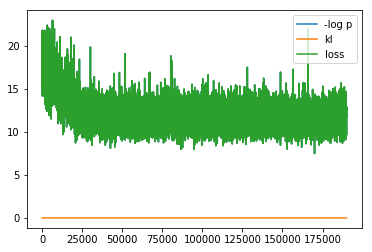

In [56]:
(pd.DataFrame({'loss': losses, 'kl': kls, '-log p': -np.array(log_likelihoods)})
   .rolling(window=20).mean().plot()
)
plt.legend()

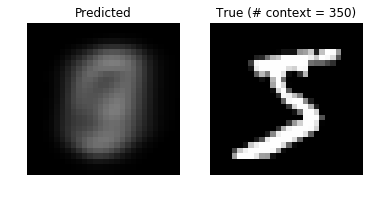

In [57]:
cnp_mode = False
n_context = 350

plot_img_pred(train_imgs[0], n_context=n_context, cnp_mode=cnp_mode)

In [66]:
def greyscale_to_rgb(img):
    return img.view((len(img), -1, 1)).expand(-1, -1, 3).clamp(0, 1)

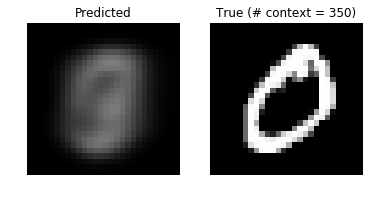

In [58]:
plot_img_pred(train_imgs[1], n_context=n_context, cnp_mode=cnp_mode)

In [730]:
r3_context = nprocess.representer(torch.cat((x[:n_context],
                                             train_imgs[0].reshape(-1, 1).to(device)[:n_context]), dim=1))
r3_context

tensor([-0.8738], device='cuda:0', grad_fn=<MeanBackward0>)

In [731]:
r3 = nprocess.representer(torch.cat((x, train_imgs[0].reshape(-1, 1).to(device)), dim=1))
r3

tensor([-0.9226], device='cuda:0', grad_fn=<MeanBackward0>)

In [732]:
nprocess.z_distribution(r3_context)

(tensor([-5.9357], device='cuda:0', grad_fn=<ThAddBackward>),
 tensor([0.9995], device='cuda:0', grad_fn=<SigmoidBackward>))

In [733]:
nprocess.z_distribution(r3)

(tensor([-5.9357], device='cuda:0', grad_fn=<ThAddBackward>),
 tensor([0.9995], device='cuda:0', grad_fn=<SigmoidBackward>))

In [41]:
def plot_samples(model: Callable[[int, torch.Tensor, torch.Tensor], torch.Tensor], n_contexts: Tuple[int]=(10, 100, 300, 784), n_preds: int=3):
    img_idx = np.random.randint(len(test_imgs))
    y = test_imgs[img_idx].reshape(-1, 1).to(device)

    np.random.shuffle(shuffle_idx)
    unshuffle_idx = np.argsort(shuffle_idx)

    fig, subplots = plt.subplots(figsize=(10, 10), nrows=n_preds + 1, ncols=len(n_contexts))

    # n_context = np.random.randint(1, len(x) // 2)
    for (context_i, n_context) in enumerate(n_contexts):
        subplots[0, context_i].imshow(test_imgs[img_idx], cmap='Greys_r')
        subplots[0, context_i].axis('off')
        subplots[0, context_i].set_title(f'{n_context} context')

        for i in range(n_preds):
            pred = model(n_context, x[shuffle_idx], y[shuffle_idx])

            try:
                pred = pred.detach()
            except AttributeError:  # not a torch.Tensor
                pass
#             subplots[i + 1, context_i].imshow(pred[unshuffle_idx].view((width, height, 1)).expand(-1, -1, 3))
            subplots[i + 1, context_i].imshow(pred[unshuffle_idx].reshape(width, height), cmap='Greys_r')
            subplots[i + 1, context_i].axis('off')

In [42]:
def get_pixel_idx(img) -> torch.Tensor:
    height, width = img.shape
    idx = torch.tensor([[i / (height - 1), j / (width - 1)] for i in range(height) for j in range(width)])
    return idx

In [160]:
def predict(img: torch.Tensor, n_context: int=100) -> torch.Tensor:
    height, width = img.shape
    pixel_idx = get_pixel_idx(img).to(device)
    img = img.reshape(-1, 1).to(device)
    
    shuffle_idx = list(range(width * height))
    np.random.shuffle(shuffle_idx)
    unshuffle_idx = np.argsort(shuffle_idx)
    
    pred, *_ = nprocess(n_context, pixel_idx[shuffle_idx], img[shuffle_idx], train=False)
    pred = pred[0][unshuffle_idx].reshape(height, width).detach()
    context_idx = pixel_idx[shuffle_idx][:n_context]
    return pred, context_idx


def plot_img_pred(img, n_context: int=100):
    pred, context_idx = predict(img, n_context)
    context_idx[:, 0] *= img.shape[0] - 1
    context_idx[:, 1] *= img.shape[1] - 1
    context_idx = context_idx.long()

    img = greyscale_to_rgb(img)
    pred = greyscale_to_rgb(pred)

    non_context_color = [0, .2, .9]
    context = np.zeros_like(img)
    context += non_context_color
    context[context_idx[:, 0], context_idx[:, 1]] = img[context_idx[:, 0], context_idx[:, 1]]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(pred)
    plt.axis('off')
    plt.title('Predicted')

    plt.subplot(1, 3, 2)
    plt.imshow(context)
    plt.axis('off')
    plt.title(f'Context ({n_context})')

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True')

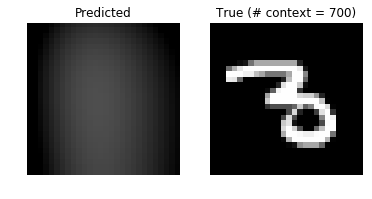

In [123]:
plot_img_pred(train_imgs[4], n_context=700)

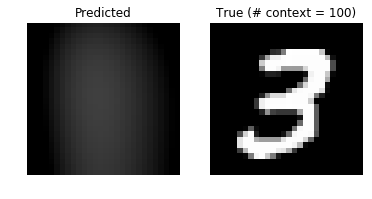

In [124]:
plot_img_pred(train_imgs[0])

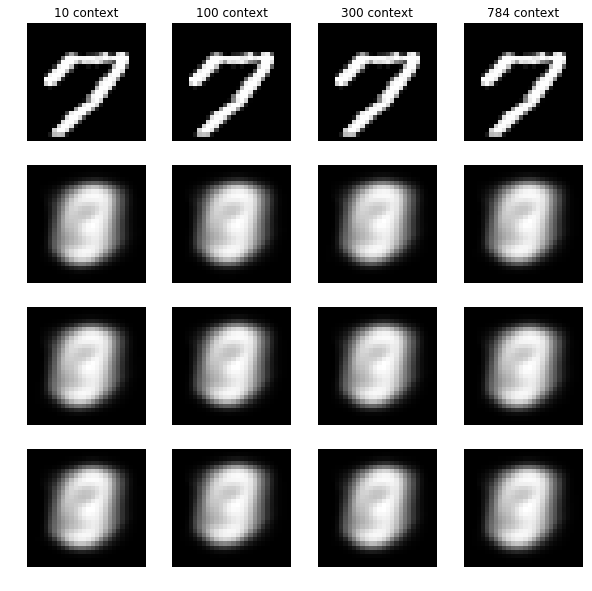

In [365]:
plot_samples(lambda *args: nprocess(*args, train=False)[0][0])